In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [12]:
image_dir = Path('C:/Users/sm160/OneDrive - Amity University/Desktop/amity/sem8/dataset/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [13]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR
1,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate
2,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR
3,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR
4,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate


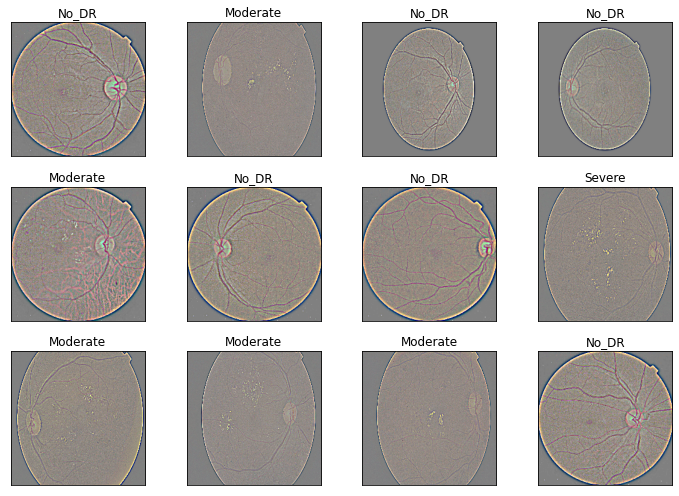

In [14]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

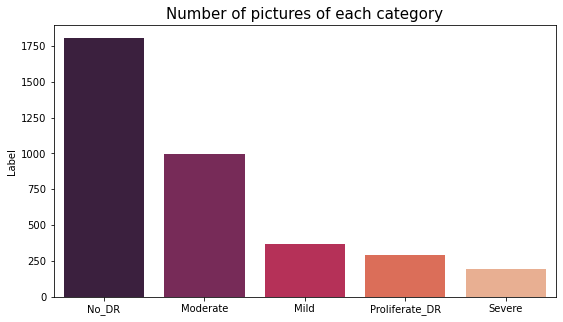

In [15]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [16]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [17]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [19]:
 #Dictionary with the models
models = {
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]


Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 404s 4s/step - loss: 0.9635 - accuracy: 0.6416 - val_loss: 0.7839 - val_accuracy: 0.7386
VGG16                trained in 404.37 sec


In [21]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results
model

{'model': <keras.engine.functional.Functional at 0x2b5e98af220>,
 'perf': 404.37,
 'val_acc': [0.7386],
 'train_accuracy': [0.6416]}

In [22]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [23]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [24]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[lr_callback],
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 360s 4s/step - loss: 1.2792 - accuracy: 0.4858 - val_loss: 1.1105 - val_accuracy: 0.5623 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 358s 4s/step - loss: 1.0464 - accuracy: 0.6278 - val_loss: 0.9385 - val_accuracy: 0.6869 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 362s 4s/step - loss: 0.9357 - accuracy: 0.6612 - val_loss: 0.8675 - val_accuracy: 0.6991 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 358s 4s/step - loss: 0.8845 - accuracy: 0.6858 - val_loss: 0.8293 - val_accuracy: 0.7112 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 466s 5s/step - loss: 0.8494 - accuracy: 0.7036 - val_loss: 0.8029 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 459s 5s/step - loss: 0.8263 - accuracy: 0.7097 - val_loss: 0.7841 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 7/50
93/93 [==============================] - 

In [19]:
sheet1=pd.DataFrame(history.history)[['accuracy','val_accuracy']]
acc_sheet=sheet1*100
with pd.ExcelWriter('C:/Users/sm160/OneDrive - Amity University/Desktop/output2.xlsx') as writer:  
    acc_sheet.to_excel(writer, sheet_name='Sheet1')
print(acc_sheet)

     accuracy  val_accuracy
0   48.583952     56.231004
1   62.778151     68.693012
2   66.115981     69.908816
3   68.577206     71.124619
4   70.364130     71.732521
5   70.971006     72.340423
6   71.611595     73.556232
7   71.577883     72.644377
8   72.016186     72.036475
9   71.948755     72.948331
10  71.881324     73.556232
11  73.027647     73.556232
12  73.297369     75.075990
13  74.409980     74.164134
14  74.544841     75.683892
15  75.522590     74.164134
16  75.488871     74.772036
17  75.826031     75.379938
18  75.657451     75.075990
19  75.994605     75.987840
20  75.927174     75.379938
21  76.163185     75.987840
22  76.365477     75.075990
23  76.196897     75.683892
24  76.432908     75.683892
25  76.298046     75.379938
26  76.432908     76.291794
27  76.534051     75.987840
28  76.635200     75.683892
29  76.567769     76.899695
30  76.500338     75.075990
31  76.567769     76.595747
32  77.073503     75.683892
33  77.006066     75.683892
34  77.073503     75

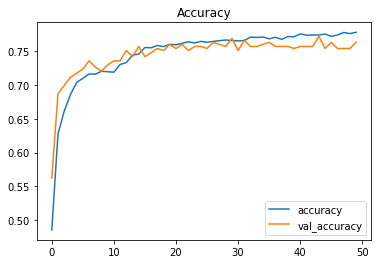

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [21]:
sheet2=pd.DataFrame(history.history)[['loss','val_loss']]
print(sheet2)
with pd.ExcelWriter('C:/Users/sm160/OneDrive - Amity University/Desktop/output3.xlsx') as writer:  
    sheet2.to_excel(writer, sheet_name='Sheet2')

        loss  val_loss
0   1.279234  1.110507
1   1.046422  0.938462
2   0.935737  0.867463
3   0.884514  0.829268
4   0.849396  0.802930
5   0.826316  0.784139
6   0.806511  0.773270
7   0.793805  0.769483
8   0.781632  0.754766
9   0.772079  0.741684
10  0.768466  0.729087
11  0.750834  0.697221
12  0.717886  0.668869
13  0.699420  0.656614
14  0.691528  0.667691
15  0.673140  0.664739
16  0.651993  0.645337
17  0.644920  0.640278
18  0.643354  0.644185
19  0.642022  0.638081
20  0.642230  0.628086
21  0.635446  0.629467
22  0.632840  0.627143
23  0.631739  0.633862
24  0.630232  0.621093
25  0.627014  0.620102
26  0.627787  0.624803
27  0.623575  0.617283
28  0.623697  0.617885
29  0.619768  0.622014
30  0.622766  0.614995
31  0.616738  0.618376
32  0.615845  0.617500
33  0.612972  0.617839
34  0.611715  0.620585
35  0.610442  0.616313
36  0.607673  0.611184
37  0.611197  0.608104
38  0.604508  0.614941
39  0.605346  0.617392
40  0.603161  0.609338
41  0.602483  0.607278
42  0.59980

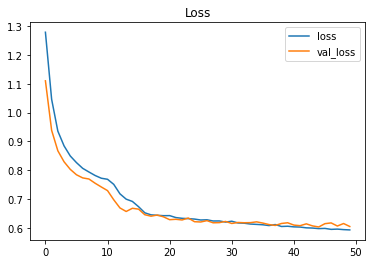

In [22]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [23]:
for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])

In [24]:
results = model.evaluate(test_images, verbose=0)

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

12/12 [==============================] - 34s 3s/step
The first 5 predictions: ['Moderate', 'Moderate', 'No_DR', 'No_DR', 'Moderate']


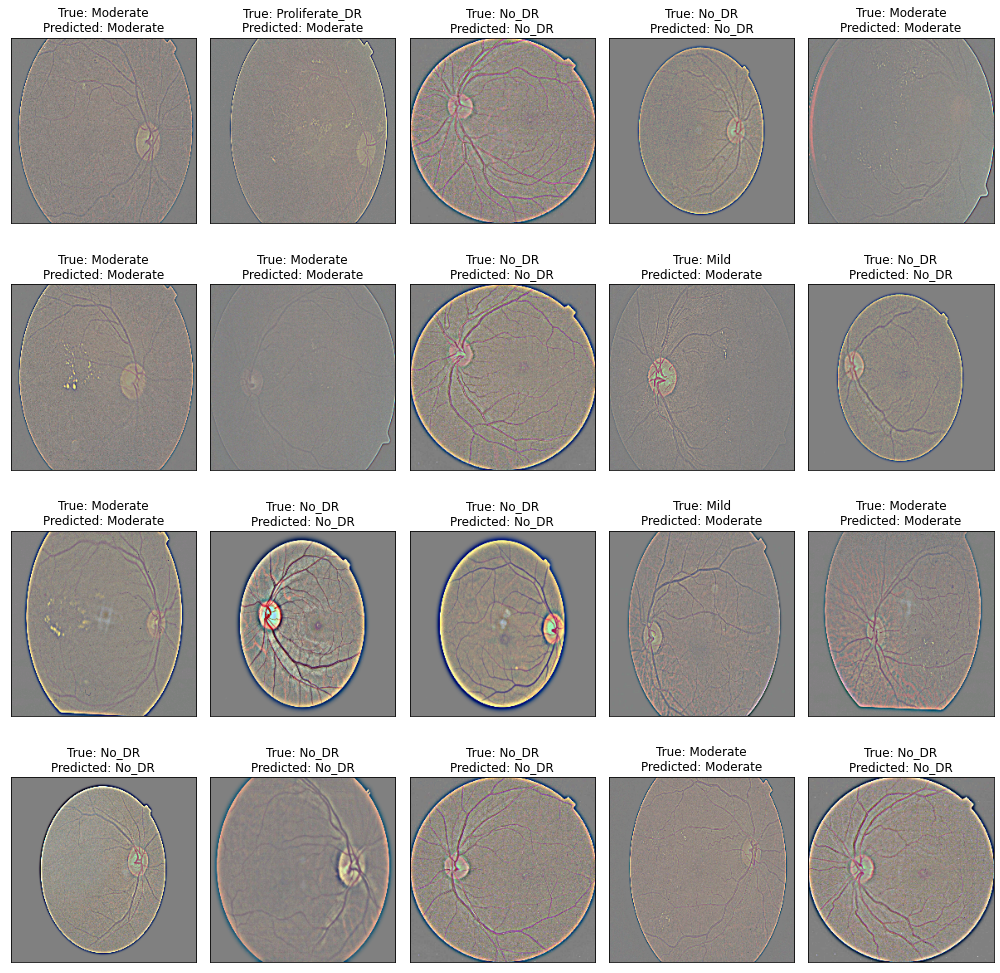

In [26]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 14),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

[[111, 16, 21, 1, 0], [0, 85, 0, 2, 4], [1, 2, 43, 8, 2], [2, 9, 1, 21, 3], [7, 3, 8, 5, 12]]


<Figure size 1080x720 with 0 Axes>

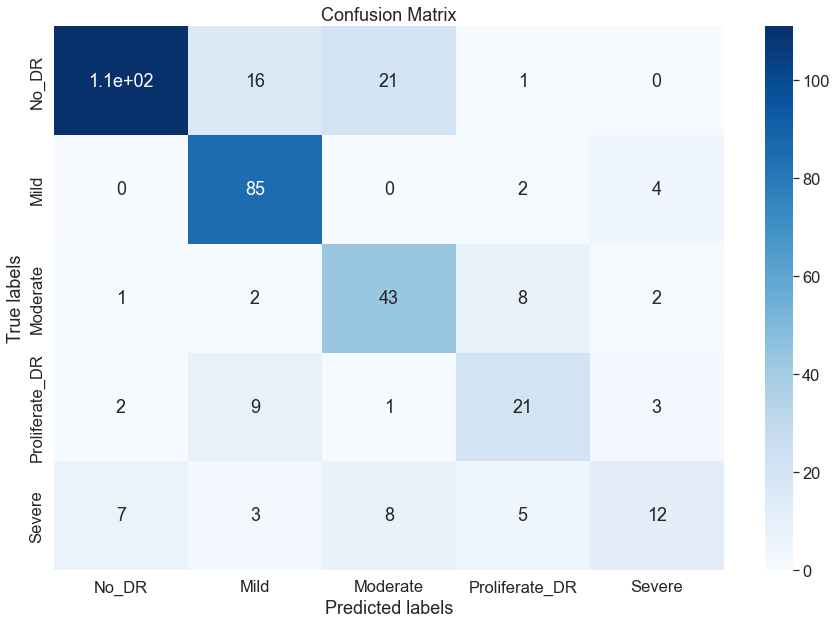

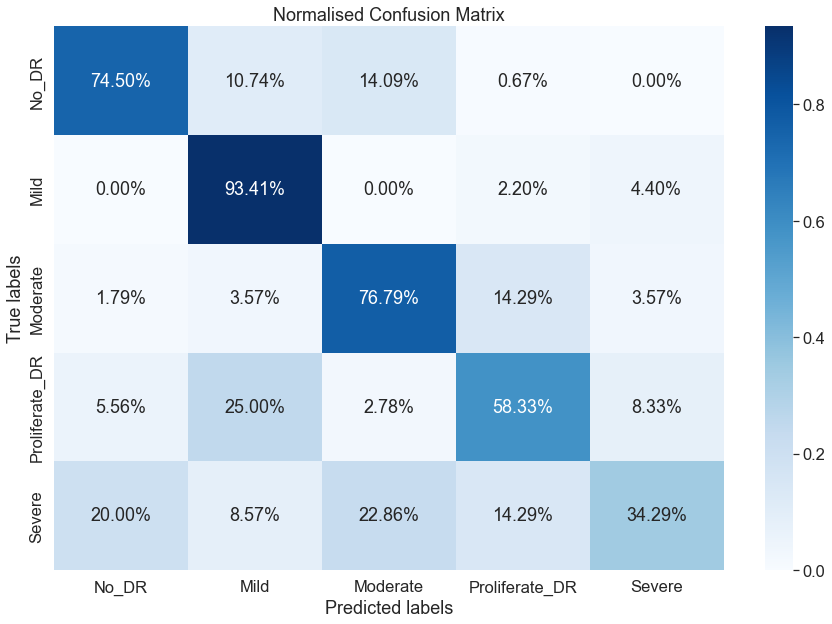

In [26]:
#VGG
# sns.heatmap(cm, annot=True,cmap="Blues",ax=ax)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

cm=[[111,16,21,1,0],[0,85,0,2,4],[1,2,43,8,2],[2,9,1,21,3],[7,3,8,5,12]]
print(cm)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues",ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

ax.xaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]); ax.yaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]);

#--------------------------
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax= plt.subplot()

confusion_matrix=np.array([[111,16,21,1,0],[0,85,0,2,4],[1,2,43,8,2],[2,9,1,21,3],[7,3,8,5,12]])
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, cmap="Blues",fmt='.2%')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalised Confusion Matrix');

ax.xaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]); ax.yaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]);
